In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

2024-05-07 11:14:48.342065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 11:14:48.342131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 11:14:48.342158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 11:14:48.349516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs", len(logical_gpus), "logical GPUs")
  except RuntimeError as e:
    print(e)

print("Tf will attempt to allocate only as much GPU Memory as needed for runtime allowed")


1 Physical GPUs 1 logical GPUs
Tf will attempt to allocate only as much GPU Memory as needed for runtime allowed


2024-05-07 11:14:51.440110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38198 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [3]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 1000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 10
classes = 10

In [4]:
data_dir = "ekush_small"
d=64
batch_size = 1

In [5]:
class Dataset:
    def __init__(self, training, ds=None):
        split = "train" if training else "test"
        self.data = {}

        def extraction(image, label):
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, [d, d])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, d, d, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, d, d, 3))

        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [6]:
def conv_ms(x, filter_size=64):
    x1 = layers.Conv2D(filters=filter_size, kernel_size=3, strides=2, padding="same")(x)
    x2 = layers.Conv2D(filters=filter_size, kernel_size=5, strides=2, padding="same")(x)

    x3 = layers.Add()([x1, x2])
    x3 = layers.BatchNormalization()(x3)

    return layers.ReLU()(x3)

def conv_bn(x, filter_size=64,kernel_size=3):
    x = layers.Conv2D(filters=filter_size, kernel_size=kernel_size, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(d, d, 3))
x = conv_ms(inputs)
x = conv_bn(x,kernel_size=1)
x = conv_ms(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           4864      ['input_1[0][0]']             
                                                                                                  
 add (Add)                   (None, 32, 32, 64)           0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(d, d),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(d, d),
  batch_size=batch_size)


train_ds = train_ds.unbatch()
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.uint8), y))

val_ds = val_ds.unbatch()
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.uint8), y))

Found 2500 files belonging to 50 classes.
Using 2000 files for training.


2024-05-07 11:14:51.834028: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 2500 files belonging to 50 classes.
Using 500 files for validation.


In [9]:
labels_name = os.listdir(data_dir)
labels_name.sort()
labels_name[2]

'103'

In [10]:
train_dataset = Dataset(training=True, ds=train_ds)
test_dataset = Dataset(training=False, ds=val_ds)

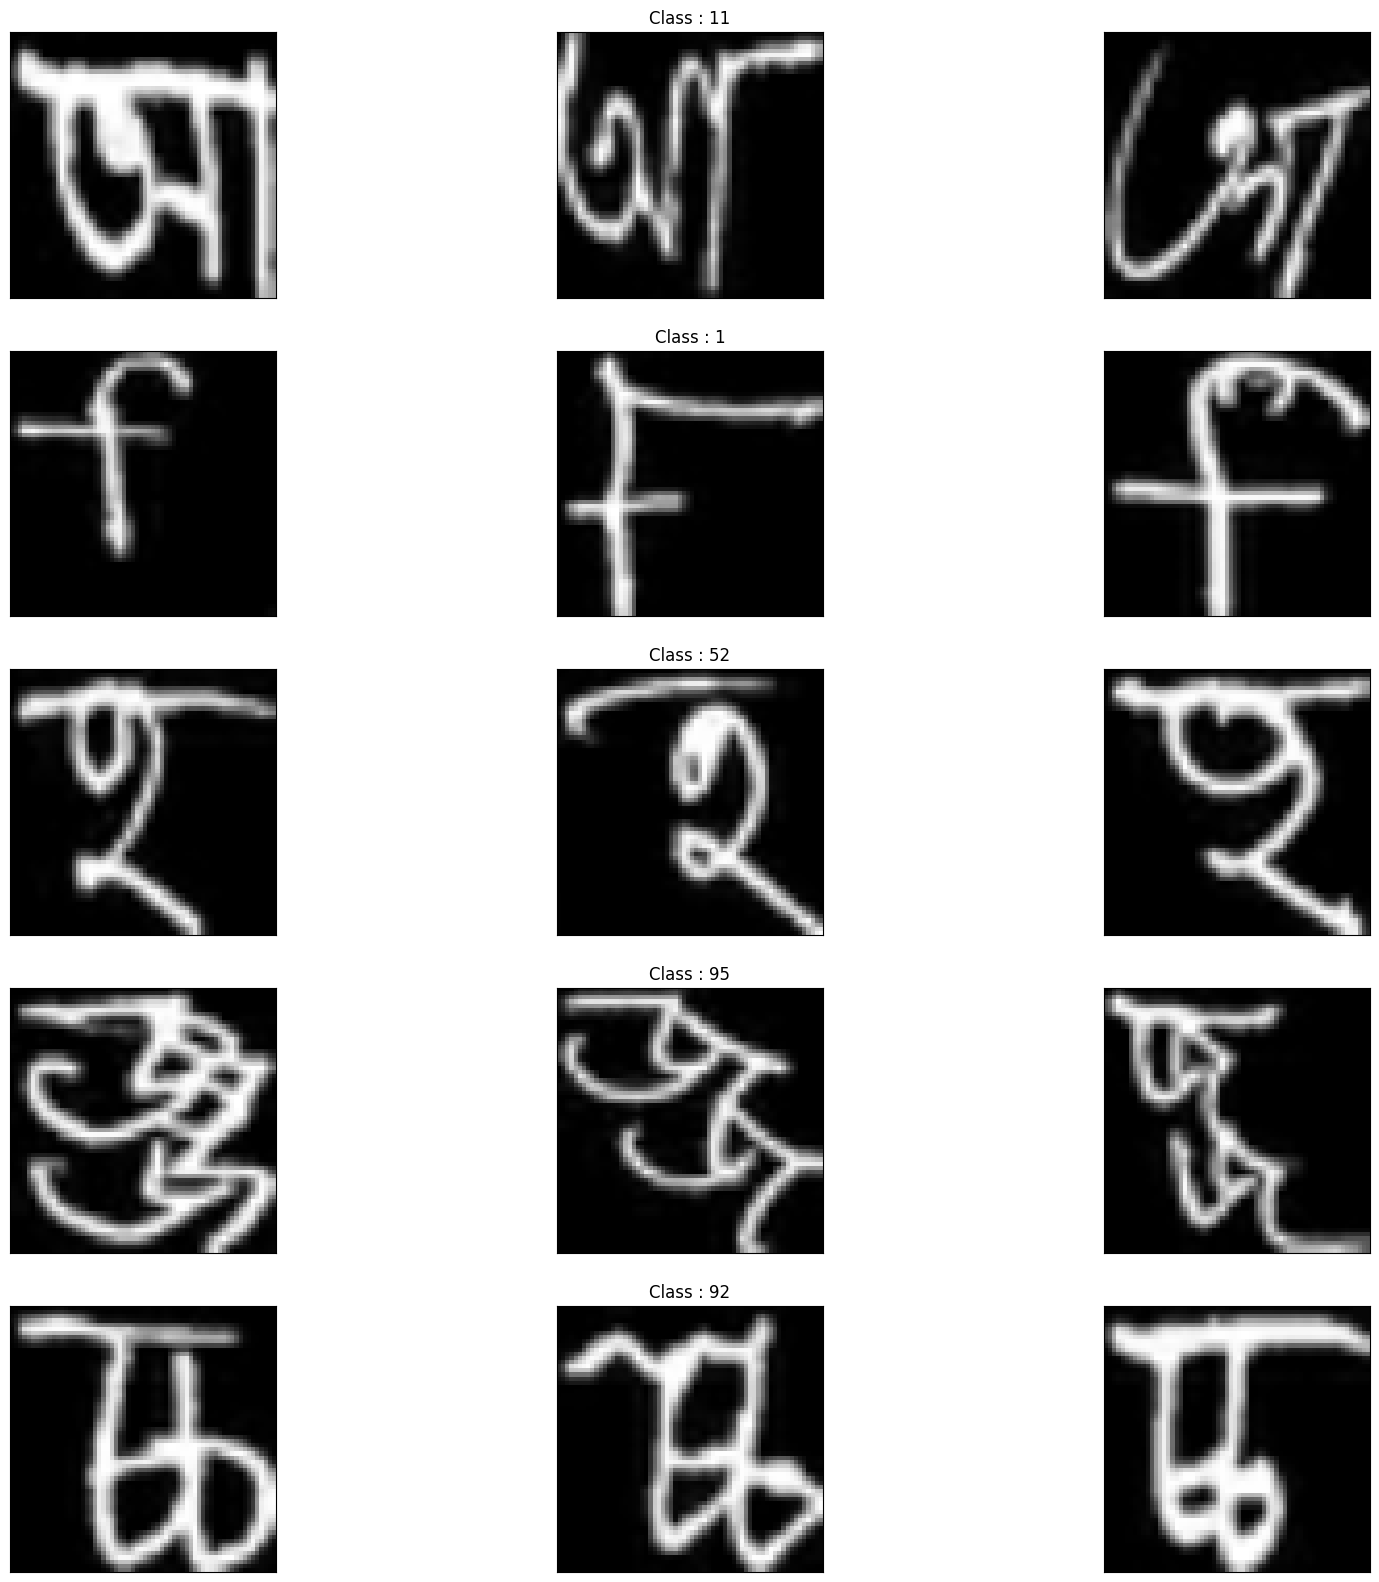

In [11]:
_, axarr = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(3):
        temp_image = train_dataset.data[sample_keys[a]][b]
        # temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        # temp_image *= 255
        # temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 1:
            axarr[a, b].set_title("Class : " + labels_name[int(sample_keys[a])])
        axarr[a, b].imshow(temp_image)
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [12]:
training = [0]
testing = [0]
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)

    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        if(accuracies[1] > testing[-1]):
          model.save_weights("./best_weights_ms.h5", overwrite=True)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


2024-05-07 11:14:54.880757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-07 11:14:55.385001: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-07 11:14:55.939749: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8c28b8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-07 11:14:55.939818: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-05-07 11:14:56.002788: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 19ms/step
batch 0: train=0.600000 test=0.400000
1/1 [==============================] - 0s 18ms/step
batch 100: train=0.500000 test=0.900000
1/1 [==============================] - 0s 20ms/step
batch 200: train=0.500000 test=0.700000
1/1 [==============================] - 0s 22ms/step
batch 300: train=0.600000 test=0.800000
1/1 [==============================] - 0s 19ms/step
batch 400: train=0.900000 test=0.800000
1/1 [==============================] - 0s 18ms/step
batch 500: train=0.800000 test=1.000000
1/1 [==============================] - 0s 18ms/step
batch 600: train=0.700000 test=0.900000
1/1 [==============================] - 0s 18ms/step
batch 700: train=0.800000 test=0.800000
1/1 [==============================] - 0s 18ms/step
batch 800: train=0.500000 test=0.600000
1/1 [==============================] - 0s 18ms/step
batch 900: train=0.700000 test=0.800000
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


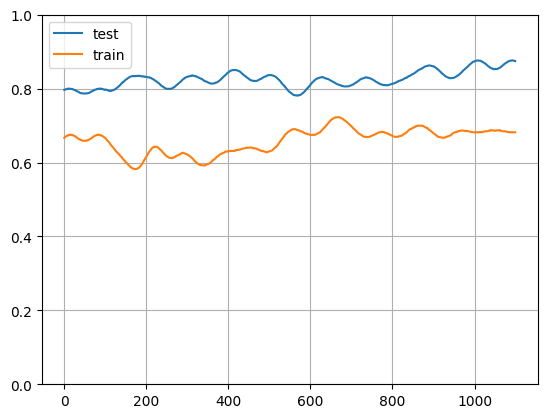

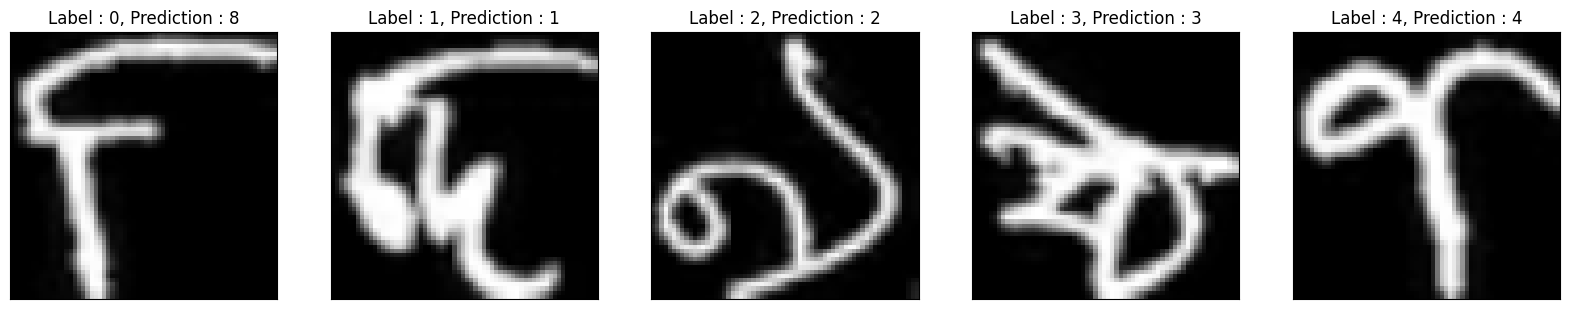

In [13]:
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.ylim(0, 1)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [14]:
test_y[-1], train_y[-1]

(0.8745102453871576, 0.6819054062537115)